# Trabajo práctico 2
**Algebra Lineal computacional, 2do cuatrimestre 2023, Universidad de Buenos Aires**

Tobias Llop, LU 871/22

Felipe Pasquet, LU 1084/22


## Ejercicio 1

### a) importamos los datos

In [2]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

In [3]:
#Importamos los datos
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wine.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### b) separamos nuestros datos en las variables dependientes (X) e independientes (Y).

In [4]:
y = data['Customer_Segment']
X = data.drop(columns='Customer_Segment')

### c) Normalización
Como nuestros datos tienen variables de distinta naturaleza, que se miden de distintas maneras y con distintas escalas, normalizaremos nuestros datos para que un atributo no tenga mayor importancia en nuestra predicción final simplemente por la escala en la que estaba medido. Normalizar los datos, hace que todos estén alrededor del 0 y podamos ver la varianza real de ellos.
A continuación normalizaremos nuestras variables dependientes $x_i$, para ello diseñamos distintas funciones que se basan en las siguientes fórmulas mátematicas:

$ s = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (X_i - \overline{X})^2}$

$\overline{X} = \frac{1}{N} \sum_{i=1}^{N} X_i$

$x_i = \frac{X_i - \overline{X}}{s}$

donde $s$ es el desvío estandar, implementado en nuestra funcíon *desvio*, $\overline{X}$ es el promedio de cada variable dependiente y está implementado en nuestra función  *promedio*. Por último la función $x_i$ es la fórmula que normaliza y centra nuestras variables y está implementada en la función *normalizar*.

In [5]:
# creamos funciones para calcular el promedio y la desviacion estandar
def promedio(x):
    res = 0
    for i in x:
        res += i
    return res/len(x)

def desviacion(x):
    res = 0
    for i in x:
        res += (i-promedio(x))**2
    return np.sqrt(res/(len(x)-1))

def normalizar(x):
    return (x-promedio(x))/desviacion(x)

A continuación utilizaremos las funciones anteriores y normalizaremos nuestras variables dependientes. Este paso es importante ya que a la hora de comparar nuestras variables deben estar escaladas, sino aquellas variables cuya escala sea mayor dominarán al resto.

In [6]:
var_dependientes_normalizados = X.copy()
def normalizar_df(df):
    promed = []
    desviac = []
    for x in df.columns:
        promed.append(promedio(df[x]))
        desviac.append(desviacion(df[x]))
        df[x] = normalizar(df[x])
    return df, promed, desviac
var_dependientes_normalizados, prom, desv = normalizar_df(var_dependientes_normalizados)
var_dependientes_normalizados_mat = var_dependientes_normalizados.to_numpy()

### d) Matriz de covarianza
El siguiente paso que realizaremos con nuestras variables dependientes será calcular su matriz de covarianza. La matriz de covarianza es una matriz cuadrada que contiene la covarianza entre los elementos de un vector. En este caso contendrá la covarianza entre nuestras 13 variables dependientes y será de dimensión $13\times13$.

Esta matriz cumple distintas propiedades:
1. Es simétrica
2. Los elementos de la diagonal principal de la matriz de covarianza representan las varianzas de las variables individuales
3. Los elementos fuera de la diagonal principal representan las covarianzas entre las diferentes variables. Un valor positivo indica una relación positiva, un valor negativo indica una relación negativa, y un valor cercano a cero indica una relación débil o nula entre las variables.

Calcularemos la matriz de covarianza utilizando la función predefinida *numpy.cov()* de la biblioteca numpy.


In [7]:
def covarianza(data):
    num_variables = len(data[0])
    num_observaciones = len(data)

    # Calculamos la media de cada variable
    means = [sum(variable) / num_observaciones for variable in zip(*data)]

    # Inicializamos la matriz de covarianza con ceros
    res = np.zeros((num_variables,num_variables))

    # Calculamos los términos de la matriz de covarianza
    for i in range(num_variables):
        for j in range(num_variables):
            res[i][j] = sum((data[k][i] - means[i]) * (data[k][j] - means[j]) for k in range(num_observaciones)) / (num_observaciones - 1)
    return res

# Calculamos la matriz de covarianza
matriz_covarianza = covarianza(var_dependientes_normalizados_mat)

### e) Método de la potencia
Nuestro siguiente objetivo es encontrar el máximo de los autovalores, y su correspondiente autovector, de la matriz de covarianza hallada en el item anterior.

Para ello utilizaremos el conocido **método de la potencia**.

Diseñamos la  función `metodo_potencia` que toma como entrada la matriz $A$ y un vector inicial $v_0$.  Definimos criterio para detener las iteraciones del método a la iteración en la que la diferencia absoluta entre dos valores propios sucesivos sea menor que $1 \times 10^{-8}$.

La función devuelve el valor propio dominante `r_actual` como el máximo autovalor $\lambda$ y a su autovector asociado correspondiente $v$.

In [8]:
def metodo_potencia(A, x0):
    x = x0
    r_ant = 0
    while True:
        x_nuevo = (A @ x) / np.linalg.norm(A @ x) #Multiplicamos A por x y normalizamos
        r_actual = x_nuevo @ A @ x_nuevo # Calculamos el autovalor actual
        if np.abs(r_actual - r_ant) < 1e-8:
            break
        x = x_nuevo
        r_ant = r_actual
    return x, r_actual

#Definimos un vector random de R^13 para inicializar el método de la potencia.
x0 = np.random.rand(13)

#Ejecutamos el metodo de la potencia para nuestra matriz de covarianza
autovector, autovalor = metodo_potencia(matriz_covarianza, x0)
print("Autovector:", autovector)
print("Autovalor máximo:", autovalor)

Autovector: [ 0.14435538 -0.24517549 -0.00203407 -0.23932097  0.14200814  0.39466434
  0.42293412 -0.29853155  0.3134316  -0.08858823  0.29669956  0.37615857
  0.28677183]
Autovalor máximo: 4.70585025119514


### f) n maximos (Preguntar por lo ultimo)
A continuación hallaremos no solo el autovalor máximo y su correspondiente autovector, sino que ampliaremos el método de la potencia para que calcule sus $n$ autovalores máximos y autovectores correspondientes sucesivos.

Para ello, definimos nuestra función `n_maximos` que toma como valores de entrada a la matriz de covarianza, un vector de $ℝ^{13}$ para inicializar el método de la potencia y un entero $n$ que indica los $n$ autovalores y autovectores máximos que querramos. Luego devuelve dos listas, una con los autovalores y otra con los autovectores.

In [9]:
def n_maximos(A, x0, n):
    autovalores = []
    autovectores = []
    for i in range(n):
      x, r_actual = metodo_potencia(A,x0)
      # Guardamos el aval y avec maximo
      autovalores.append(r_actual)
      autovectores.append(x)
      # Deflacionamos la matriz A
      A = A - r_actual * np.outer(x, x)
    return autovalores, autovectores

La cantidad de autovalores de nuestra matriz de covarianza es la misma que la cantidad de propiedades de los vinos.

Cada autovector de la matriz de covarianza son distintas direcciones en las que se mueven nuestros datos.

### g) Clasificación

La idea del siguiente punto es que, dado un conjunto de características de un vino en particular, obtener su clasificación, es decir, a qué segmento de cliente pertenece. Para ello utilizaremos la función `clasificarVino`, que recibe un vector de $1\times 13$ asociado a las caracteristicas de un vino, una matriz $W$ de componentes principales de nuestros datos y un número $k$ asociado a la cantidad de vecinos más cercanos con la que queremos realizar el algoritmo knn. La función va a devolver un número dentro del intervalo [1,2,3] asociado a la clasificación del segmento de cliente al que pertenecen las características del vino particular.


In [10]:
#Busco las 13 componentes principales
x0 = np.random.rand(13)
autovalores, autovectores = n_maximos(matriz_covarianza,x0,13)

#Ponemos a cada componente principal como columna de nustra matriz W
def armar_W(n, avecs):
  W = np.zeros((13,n))
  for i in range(13):
      for j in range(n):
          v = avecs[j]
          W[i][j] = v[i]
  return W
#Armamos nuestra matriz con 13 componentes principales
W = armar_W(13, autovectores)
def distancia(v1,v2):
  return np.linalg.norm(v1 - v2)

def clasificarVino(x,W,k,data,clas):
  #x es el vino que queremos clasificar
  #W son las componentes principales que utilizaremos
  #k es la cantidad de vecinos
  #data es el dataset con el que vamos a entrenar nuestro modelo
  #clas es la clasificacion de nuestra data

  T = data@W #Proyectamos todos los datos sobre nuestras componentes principales
  vino = x@W #Proyectamos los datos de las caracteristicas del nuevo vino sobre nuestras componentes principales
  distancias = [] #Inicializamos una lista donde guardaremos todas las distancias euclideas
  ap_1 = 0
  ap_2 = 0
  ap_3 = 0
  res = 0
  for i in range(len(T)):
      #Guardamos las distancias y la posición en la que se encontraba en nuestros datos
      distancias.append((distancia(T[i], vino), clas[i])) #posicion(data[i], var_dependientes_normalizados_mat)))
  #Ordenamos las distancias para que primero se encuentren las más cercanas
  distancias.sort(key=lambda distancias: distancias[0])

  #Contamos apariciones
  for i in range(k):

    if distancias[i][1] == 1.0:
      ap_1 += 1
    elif distancias[i][1] == 2.0:
      ap_2 += 1
    elif distancias[i][1] == 3.0:
      ap_3 += 1
  #Vemos quien tiene más apariciones
  if ap_3 >= ap_2 and ap_3 >= ap_1:
      res = 3.0
  elif ap_2 >= ap_3 and ap_2 >= ap_1:
      res = 2.0
  elif ap_1 >= ap_2 and ap_1 >= ap_3:
      res = 1.0
  #Devolvemos la clase mas representada entre los k vecinos
  return res

#Ejemplo

#x = np.array([13.0, 1.72, 2.13, 11.0, 109, 2.70, 3.06, 0.32, 2.40, 8.0, 1.04, 3.90, 1185])
x = np.array([13.17,	2.59,	2.37,	20.0,	120,	1.65,	0.68,	0.53,	1.46,	9.30,	0.60,	1.62,	840])  #debería dar 3
#Normalizo los datos de mi vino
df = X.copy()
df, pr, desv = normalizar_df(df)

xn = (x-pr)/desv
#knn con 1 vecino
df = df.to_numpy()
print(clasificarVino(xn,W, 1, df, y.to_numpy()))

3.0


## Ejercicio 2
Primero dividimos nuestros datos en entrenamiento y testeo.


In [29]:
#dividimos nuestro dataset en Train (80%) y test (20%)
train, test = train_test_split(data, test_size=0.2)

ytrain = train['Customer_Segment']
ytest = test['Customer_Segment']
ytrain = ytrain.to_numpy()
ytest = ytest.to_numpy()
train = train.drop(columns='Customer_Segment')
test = test.drop(columns='Customer_Segment')

In [30]:
#normalizamos nuestros datos (con nuestro train set)

train, pr, desv = normalizar_df(train)

test = (test-pr)/desv
train = train.to_numpy()
test = test.to_numpy()

### a) Varianza explicada
Para la siguiente consigna calculamos la varianza explicada de cada autovalor de nuestra matriz de covarianza. A continuación se puede ver una tabla donde se resumen los resultados:

<table>
  <thead>
    <tr>
      <th>Modelo PCA</th>
      <th>Componente</th>
      <th>Varianza explicada</th>
      <th>Porcentaje</th>
      <th>Acumulado</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1 componente principal</td>
      <td>1</td>
      <td>0.35</td>
      <td>35%</td>
      <td>35%</td>
    </tr>
    <tr>
      <td>2 componentes principales</td>
      <td>1</td>
      <td>0.35</td>
      <td>35%</td>
      <td>35%</td>
    </tr>
      <tr>
      <td>2 componentes principales</td>
      <td>2</td>
      <td>0.20</td>
      <td>20%</td>
      <td>55%</td>
    </tr>
        <tr>
      <td>3 componentes principales</td>
      <td>1</td>
      <td>0.35</td>
      <td>35%</td>
      <td>35%</td>
    </tr>
      <tr>
      <td>3 componentes principales</td>
      <td>2</td>
      <td>0.20</td>
      <td>35%</td>
      <td>55%</td>
    </tr>
        </tr>
      <tr>
      <td>3 componentes principales</td>
      <td>3</td>
      <td>0.11</td>
      <td>11%</td>
      <td>66%</td>
    </tr>
            <tr>
      <td>3 componentes principales</td>
      <td>1</td>
      <td>0.35</td>
      <td>35%</td>
      <td>35%</td>
    </tr>
      <tr>
      <td>3 componentes principales</td>
      <td>2</td>
      <td>0.20</td>
      <td>35%</td>
      <td>55%</td>
    </tr>
        </tr>
      <tr>
      <td>3 componentes principales</td>
      <td>3</td>
      <td>0.11</td>
      <td>11%</td>
      <td>66%</td>
    </tr>
      <tr>
      <td>4 componentes principales</td>
      <td>4</td>
      <td>0.07</td>
      <td>7%</td>
      <td>73%</td>
    </tr>
  </tbody>
</table>



In [31]:
matriz_covarianza_train = covarianza(train)
#Calculamos la varianza explicada para cada autovalor de nuestra matriz W de autovectores.
x0 = np.random.rand(13)
autovalores_t, autovectores_t = n_maximos(matriz_covarianza_train,x0,13)
varianza_explicada = [autovalor / np.sum(autovalores_t) for autovalor in autovalores_t]
print(varianza_explicada)

[0.36330248257898445, 0.19739140420538281, 0.1088059013872567, 0.06953206058216801, 0.057180408910828616, 0.05158612735278239, 0.0437815579208133, 0.029166980839510054, 0.020931506897416005, 0.018752544216427195, 0.0171761295197695, 0.01364066903222066, 0.008752226556440344]


### b) Comparación de modelos
Para evaluar la performance de nuestros modelos, decidimos utilizar como medida la Accuracy, para ello definimos la funcion accuracy que calcula la cantidad de aciertos de nuestro modelo sobre el total de muestras en el conjunto de test.

In [32]:
#Armo mi matriz W con 2 componentes
W = armar_W(2, autovectores_t)

#Funcion de accuracy.
def accuracy(test, train,ytest, ytrain, W, k):
  le_pego = 0 #Aciertos
  no_le_pego = 0 #Desaciertos
  for i in range(len(test)):
    if clasificarVino(test[i],W, k, train, ytrain) == ytest[i]: #Usamos KNN con k vecinos
      le_pego +=1
    else:
      no_le_pego += 1
  res = le_pego / (no_le_pego + le_pego)
  return res
accuracy(test, train, ytest, ytrain, W, 1)

0.9166666666666666

Luego, decidimos comparar valores de accuracy para distintas cantidades de componentes en nuestra matriz $W$. Para ello guardamos los datos de 20 modelos con 1,2,3 y 4 componentes en una matriz y promediamos los datos.

In [34]:
#Creamos una matriz donde almacenaremos las accuracy para distintos modelos y componentes
matriz_acu = np.zeros((20,4))
i = 0
x0 = np.random.rand(13)
while i < 20:
  #me genero un nuevo test y train set
  train, test = train_test_split(data, test_size=0.2)
  ytrain = train['Customer_Segment']
  ytest = test['Customer_Segment']
  ytrain = ytrain.to_numpy()
  ytest = ytest.to_numpy()
  train = train.drop(columns='Customer_Segment')
  test = test.drop(columns='Customer_Segment')
  # normalizo mis datos
  train, pr, desv = normalizar_df(train)
  test = (test-pr)/desv
  train = train.to_numpy()
  test = test.to_numpy()

  matriz_covarianza_train = covarianza(train)
  autovalores_t2, autovectores_t2 = n_maximos(matriz_covarianza_train,x0,4)
  for j in range(4):
    W = armar_W(j, autovectores_t2)
    matriz_acu[i][j] = accuracy(test, train, ytest, ytrain, W, 1)
  i +=1

In [35]:
promedios = []
for j in range(4):
    suma = 0
    for i in range(20):
        suma += matriz_acu[i][j]
    promedios.append(suma/matriz_acu.shape[0])
print(promedios)

[0.3402777777777778, 0.7694444444444445, 0.9513888888888886, 0.9361111111111111]


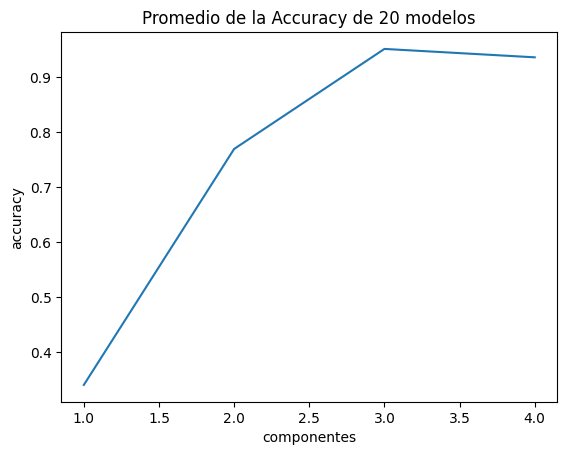

In [36]:
#Graficamos
plt.plot([1,2,3,4],promedios)
plt.title('Promedio de la Accuracy de 20 modelos')
plt.xlabel('componentes')
plt.ylabel('accuracy')
plt.show()

En el gráfico, Vemos que efectivamente, sucede lo que suponiamos. Usar dos o tres componentes presenta una mejora frente a usar una sola, pero a partir de la cuarta componente, el rendimiento/efectividad de nuestros modelos empieza a bajar.

A continuación veremos con cuantas componentes nuestro modelo es más eficiente y presenta menor complejidad a la hora de clasificar, para finalmente tomar una decisión

In [ ]:
#Buscamos las comp. principales
x0 = np.random.rand(13)
autovalores, autovectores = n_maximos(matriz_covarianza,x0,13)
#Ejemplo vino

for i in range(1,5):
  inicio = time.time()
  W = armar_W(i, autovectores) #armo matriz de componentes principales
  for x in test: #clasifico todo mi dataset (train + test)
    clasificarVino(x,W,5,train, ytrain)
  for x in train:
    clasificarVino(x,W,5,train, ytrain)
  fin = time.time()
  # Cálculo del tiempo transcurrido
  tiempo_transcurrido = fin - inicio
  print(f"La función con {i} componentes tardó {tiempo_transcurrido} segundos en ejecutarse.")

La función con 1 componentes tardó 0.1380302906036377 segundos en ejecutarse.
La función con 2 componentes tardó 0.12602901458740234 segundos en ejecutarse.
La función con 3 componentes tardó 0.14603304862976074 segundos en ejecutarse.
La función con 4 componentes tardó 0.127028226852417 segundos en ejecutarse.


Viendo que la complejidad de la función `clasificarVino` aumenta con el número de componentes, ya que al proyectar las matrices $W$ de mayor dimensión y recorrerlas la complejidad aumenta y considerando que la varianza acumulada del modelo con 2 componentes es de 55%. Tomamos la decisión de que la mejor opción para clasificar vinos es el modelo con 2 componentes, ya que tiene una accuracy similar a los modelos de 3 y 4 componentes, es más eficiente y es un indicador que toma en cuenta como varían mas de la mitad de nuestros datos.

### c) Matriz de confusión
una matriz de confusión, es una matriz de dos dimensiones, la cual
tiene en una de sus direcciones los valores de testeo verdaderos y en la otra dirección los valores estimados.

Para esta ocasión decidimos comparar entre dos categorias de vinos la 1 y la 2. En la dirección (arriba-abajo) se encuentran los valores de testeo reales y en la dirección (izquierda-derecha) se encuentran los valores predichos por el modelo.

In [28]:
avals_t, avecs_t =  n_maximos(covarianza(train),x0,13) #Obtenemos los autovectores
W = armar_W(2, avecs_t) #Creamos nuestra matriz W
#Matriz de confusion.
def confusion(test, train,ytest, ytrain, W):
  res = np.zeros((2,2))
  for i in range(len(test)):
    if clasificarVino(test[i],W, 3, train, ytrain) == ytest[i] and ytest[i] == 1: #Era 1 y clasifico bien
      res[0][0] += 1
    elif clasificarVino(test[i],W, 3, train, ytrain) == ytest[i] and ytest[i] == 2: #Era 2 y clasifico bien
      res[1][1] += 1
    elif clasificarVino(test[i],W, 3, train, ytrain) != ytest[i] and ytest[i] == 1: #Era 1 y el modelo clasifico mal
      res[0][1] += 1
    elif clasificarVino(test[i],W, 3, train, ytrain) != ytest[i] and ytest[i] == 2: #Era 2 y el modelo clasifico bien
      res[1][0] += 1
  return res
print("Matriz de confusion: \n",confusion(test, train,ytest, ytrain, W))

Matriz de confusion: 
 [[12.  1.]
 [ 0. 14.]]


Observando la matriz de confusión podemos ver que nuestro modelo KNN, es bastante bueno clasificando a nuestros datos porque tuvo una baja cantidad de desaciertos. Por lo que confirmamos que la decisión de quedarnos con la matriz de 2 componentes fue la adecuada.

## Conclusiones Finales
Finalizado el proceso de normalización de nuestros datos, modelado y evaluación de nuestros modelos, llegamos a las siguientes conclusiones:

* Es importante normalizar nuestros datos poque si las unidades de medida en diferentes atributos son distintas, los atributos con magnitudes mayores pueden dominar la variabilidad y tener un impacto desproporcionado en los componentes principales. La normalización asegura que todas los atributos tengan una escala comparable.

* La reduccion en componentes principales de nuestros datos mejora la eficiencia de nuestros modelos predictivos, y es util para clasificar nuevos vinos de una forma mas eficiente y rápida.
* El modelo con 2 componentes acumula más de la mitad de la varianza acumulada de nuestros datos con un 55%. Mientras que el modelo de 3 componentes aumenta tan solo un 11% más la varianza acumulada con respecto al modelo de dos componentes, alcanzando un 66%.
* La performance de nuestro modelo KNN no es buena para el modelo con 1 sola componente, y tiende a disminuir a partir de la cuarta componente.
* El mejor modelo para clasificar vinos con una accuracy aceptable y de forma rápida es el modelo con 2 componentes.